# CR6 Results Analysis D

## Python Imports

In [37]:
import numpy as np
import pandas as pd
from prettypandas import PrettyPandas
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api
from pyomo.environ import *

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import display, Markdown, HTML

%matplotlib inline
PlotWidth = 6

import warnings
warnings.filterwarnings('ignore')

In [38]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

def backward_regression(X, y,
                           threshold_out,
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
        
    return included

def build_model(X,values,verbose=True):
    X = [sub.replace('alh', 'model.X1') for sub in X]
    X = [sub.replace('aps', 'model.X2') for sub in X]
    X = [sub.replace('aid', 'model.X3') for sub in X]
    X = [sub.replace('arw', 'model.X4') for sub in X]
    X = [sub.replace('awt', 'model.X5') for sub in X]
    X = [sub.replace(':', '*') for sub in X]
    model = str(values[0])
    i=1
    for v in X:
        model  += " + " + str(values[i]) + " * " + v
        i += 1
    if verbose:
        print(model)
    return model

## Process CSV Files

In [39]:

# importing the pandas library
import pandas as pd
  
# reading the csv file using read_csv
# storing the data frame in variable called df
df_cost = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/cr6_cost_reduced.txt', sep='\t')
df_time = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/cr6_time_reduced.txt', sep='\t')
  
# creating a list of column names by
# calling the .columns
list_of_columns_cost = list(df_cost.columns)
list_of_columns_time = list(df_time.columns)
  
# displaying the list of column names
print('List of Cost column names : ', 
      list_of_columns_cost)
print('List of Time column names : ', 
      list_of_columns_time)

List of Cost column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'cost']
List of Time column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'time']


In [40]:
display((Markdown("### Statistics for Cost")))
df_cost.cost.describe()

### Statistics for Cost

count    48.000000
mean      0.604292
std       0.109300
min       0.530000
25%       0.563750
50%       0.570000
75%       0.590250
max       1.103000
Name: cost, dtype: float64

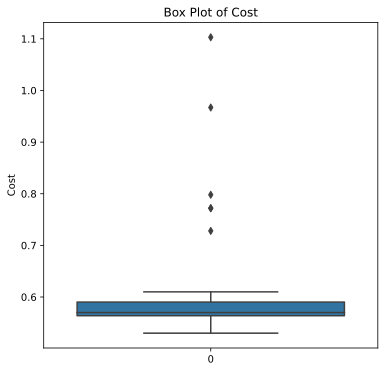

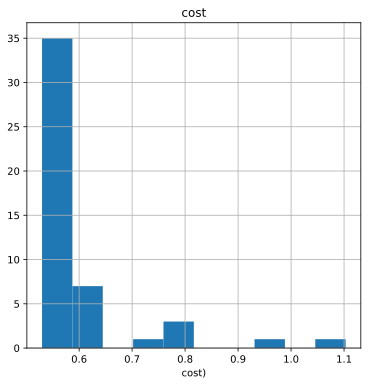

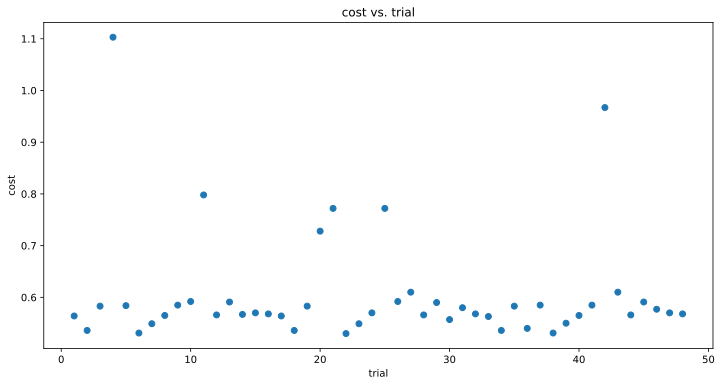

In [41]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_cost['cost'])
plt.title('Box Plot of Cost')
plt.ylabel('Cost')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_cost['cost'].hist()
plt.title('cost')
plt.xlabel('cost)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_cost['trial'], df_cost['cost'])
plt.title('cost vs. trial')
plt.xlabel('trial')
plt.ylabel('cost')
plt.show()

In [42]:
display((Markdown("### Statistics for Time")))
df_time.time.describe()

### Statistics for Time

count       48.000000
mean     12741.250000
std       3350.867798
min       8492.000000
25%       9560.750000
50%      12989.000000
75%      15517.750000
max      18098.000000
Name: time, dtype: float64

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_time['time'])
plt.title('Box Plot of Time')
plt.ylabel('Time')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_time['time'].hist()
plt.title('time')
plt.xlabel('time)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_time['trial'], df_time['time'])
plt.title('time vs. trial')
plt.xlabel('trial')
plt.ylabel('time')
plt.show()

# Cost Analysis

In [43]:
f = 'cost ~ (alh+aps+aid+arw+awt)**2'
y, X = patsy.dmatrices(f, df_cost, return_type='dataframe')
print(y[:5])
print(X[:5])

    cost
0  0.564
1  0.536
2  0.583
3  1.103
4  0.584
   Intercept   alh   aps   aid  arw  awt  alh:aps  alh:aid  alh:arw  alh:awt  \
0        1.0  0.16  50.0  0.25  0.4  0.8      8.0    0.040    0.064    0.128   
1        1.0  0.28  50.0  0.25  0.4  1.2     14.0    0.070    0.112    0.336   
2        1.0  0.16  60.0  0.25  0.4  1.2      9.6    0.040    0.064    0.192   
3        1.0  0.28  60.0  0.25  0.4  0.8     16.8    0.070    0.112    0.224   
4        1.0  0.16  50.0  0.15  0.4  1.2      8.0    0.024    0.064    0.192   

   aps:aid  aps:arw  aps:awt  aid:arw  aid:awt  arw:awt  
0     12.5     20.0     40.0     0.10     0.20     0.32  
1     12.5     20.0     60.0     0.10     0.30     0.48  
2     15.0     24.0     72.0     0.10     0.30     0.48  
3     15.0     24.0     48.0     0.10     0.20     0.32  
4      7.5     20.0     60.0     0.06     0.18     0.48  


                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1.511
Date:                Sat, 31 Jul 2021   Prob (F-statistic):              0.159
Time:                        21:55:15   Log-Likelihood:                 51.505
No. Observations:                  48   AIC:                            -71.01
Df Residuals:                      32   BIC:                            -41.07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0785      1.411     -0.764      0.4

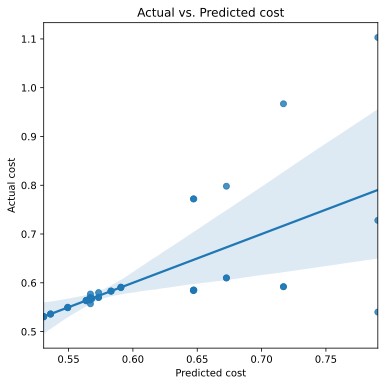

In [44]:

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

## Reduced Cost Model

In [45]:
cost_included = backward_regression(X,y,.05)
cost_included.pop(0)
print(cost_included)

Drop alh                            with p-value 0.815537
Drop aid                            with p-value 0.82308
Drop arw:awt                        with p-value 0.684097
Drop aid:arw                        with p-value 0.609619
Drop alh:arw                        with p-value 0.467996
Drop aps                            with p-value 0.403632
Drop alh:aid                        with p-value 0.33927
Drop aps:awt                        with p-value 0.153601
['arw', 'awt', 'alh:aps', 'alh:awt', 'aps:aid', 'aps:arw', 'aid:awt']


                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     2.884
Date:                Sat, 31 Jul 2021   Prob (F-statistic):             0.0155
Time:                        21:55:16   Log-Likelihood:                 48.459
No. Observations:                  48   AIC:                            -80.92
Df Residuals:                      40   BIC:                            -65.95
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4285      0.296     -1.450      0.1

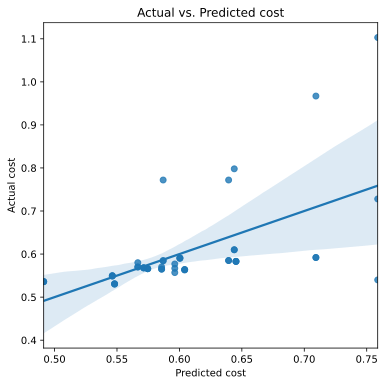

In [46]:
y = df_cost['cost']
#y = df_cost['time']
X = X[cost_included]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

In [47]:
cost_eq = build_model(cost_included,results.params,False)
print("Cost = " + cost_eq)

Cost = -0.42845690440688455 + 1.7416020232770073 * model.X4 + 0.8905702072288415 * model.X5 + 0.036331471770285895 * model.X1*model.X2 + -1.995761594689216 * model.X1*model.X5 + 0.06002388751391756 * model.X2*model.X3 + -0.030896551938369682 * model.X2*model.X4 + -2.7200132819860827 * model.X3*model.X5


# Time Analysis

In [48]:
f = 'time ~ (alh+aps+aid+arw+awt)**2'
y, X = patsy.dmatrices(f, df_time, return_type='dataframe')
print(y[:5])
print(X[:5])

      time
0  18098.0
1   8741.0
2  14493.0
3  10281.0
4  14914.0
   Intercept   alh   aps   aid  arw  awt  alh:aps  alh:aid  alh:arw  alh:awt  \
0        1.0  0.16  50.0  0.25  0.4  0.8      8.0    0.040    0.064    0.128   
1        1.0  0.28  50.0  0.25  0.4  1.2     14.0    0.070    0.112    0.336   
2        1.0  0.16  60.0  0.25  0.4  1.2      9.6    0.040    0.064    0.192   
3        1.0  0.28  60.0  0.25  0.4  0.8     16.8    0.070    0.112    0.224   
4        1.0  0.16  50.0  0.15  0.4  1.2      8.0    0.024    0.064    0.192   

   aps:aid  aps:arw  aps:awt  aid:arw  aid:awt  arw:awt  
0     12.5     20.0     40.0     0.10     0.20     0.32  
1     12.5     20.0     60.0     0.10     0.30     0.48  
2     15.0     24.0     72.0     0.10     0.30     0.48  
3     15.0     24.0     48.0     0.10     0.20     0.32  
4      7.5     20.0     60.0     0.06     0.18     0.48  


                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     104.1
Date:                Sat, 31 Jul 2021   Prob (F-statistic):           8.50e-23
Time:                        21:55:16   Log-Likelihood:                -363.43
No. Observations:                  48   AIC:                             758.9
Df Residuals:                      32   BIC:                             788.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.522e+04   8012.964      4.395      0.0

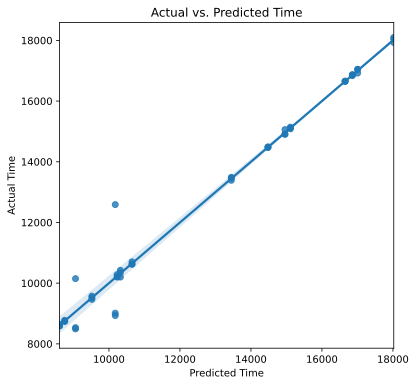

In [49]:
## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted Time')
plt.ylabel('Actual Time')
plt.title('Actual vs. Predicted Time')
plt.show()

## Time Reduced Model

In [50]:
time_included = backward_regression(X,y,.05)
time_included.pop(0)
print(time_included)

Drop aps                            with p-value 0.696191
Drop aid:arw                        with p-value 0.660248
Drop alh:aps                        with p-value 0.421652
Drop aps:awt                        with p-value 0.481372
Drop arw:awt                        with p-value 0.320028
Drop aps:aid                        with p-value 0.249867
Drop alh:arw                        with p-value 0.0837994
['alh', 'aid', 'arw', 'awt', 'alh:aid', 'alh:awt', 'aps:arw', 'aid:awt']


In [51]:
y = df_time['time']
X = X[time_included]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted Time')
plt.ylabel('Actual Time')
plt.title('Actual vs. Predicted Time')
plt.show()

ValueError: The indices for endog and exog are not aligned

In [ ]:
time_eq = build_model(time_included,results.params,False)
print("Time = " + time_eq)

## Equations

In [ ]:
display(Markdown("Cost = "))
print(cost_eq)

print("------")

display(Markdown("Time = "))
print(time_eq)


# Optimization

In [ ]:
model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)
model.X3 = Var(within=NonNegativeReals)
model.X4 = Var(within=NonNegativeReals)
model.X5 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= .28)
model.C2 = Constraint(expr = model.X2 <= 60)
model.C3 = Constraint(expr = model.X3 <= .25)
model.C4 = Constraint(expr = model.X4 <= .8)
model.C5 = Constraint(expr = model.X5 <= 1.2)

model.C6 = Constraint(expr = model.X1 >= .16)
model.C7 = Constraint(expr = model.X2 >= 50)
model.C8 = Constraint(expr = model.X3 >= .15)
model.C9 = Constraint(expr = model.X4 >= .4)
model.C10 = Constraint(expr = model.X5 >= .8)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr = model.f1 == (0.022179997348888314 + 0.9805362539766707 * model.X4 + 0.4210264448568395 * model.X5 + 0.055398409331918294 * model.X2*model.X3 + -0.016249522799575436 * model.X2*model.X4 + -2.5398197242841984 * model.X3*model.X5))
model.C_f2 = Constraint(expr = model.f2 == (39383.12499999856 + -78995.06592013844 * model.X1 + -129.4773731249602 * model.X2 + -8759.911472760796 * model.X5 + -45752.146814405125 * model.X1*model.X3 + 12225.825471698428 * model.X1*model.X4 + 28897.916666666522 * model.X1*model.X5 + 440.7227146814413 * model.X2*model.X3 + -57.37028301886791 * model.X2*model.X4 + -11750.650969529073 * model.X3*model.X5))
model.O_f1 = Objective(expr = model.f1, sense=minimize)
model.O_f2 = Objective(expr = model.f2, sense=minimize)

# max f1 separately
# install glpk solver:  sudo apt-get install glpk-utils
model.O_f2.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_min = value(model.f2)

# max f2 separately
model.O_f2.activate()
model.O_f1.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_max = value(model.f2)

# apply augmented $\epsilon$-Constraint
# max   		f1 + delta*s
# constraint 	f2 - s = e
model.O_f1.activate()
model.O_f2.deactivate()

model.del_component(model.O_f1)
model.del_component(model.O_f2)

model.e = Param(initialize=0, mutable=True)
model.delta = Param(initialize=0.00001)
model.slack = Var(within=NonNegativeReals)
model.O_f1 = Objective(expr = model.f1 + model.delta * model.slack, sense=minimize)
model.C_e = Constraint(expr = model.f2 - model.slack == model.e)

n = 100
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l, x2_l, x3_l, x4_l, x5_l = [], [], [], [], []
f1_l, f2_l = [], []
for i in steps:
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
    x3_l.append(value(model.X3))
    x4_l.append(value(model.X4))
    x5_l.append(value(model.X5))
    f1_l.append(value(model.f1))
    f2_l.append(value(model.f2))
    # print(i, value(model.X1), value(model.X2), value(model.f1), value(model.slack), value(model.f2))

